# PROJECT REVIEW

In [1]:
# import modules
% matplotlib inline

import re
import os
import pylab
import tkFont
import random
import collections
import numpy as np
import Tkinter as tk
import cPickle as pkl
from lasagne import layers, updates
from scipy.misc import imread, imresize
from lasagne.nonlinearities import softmax
from scipy.ndimage.filters import maximum_filter
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.image import extract_patches
from nolearn.lasagne import NeuralNet, BatchIterator, visualize

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [4]:
# declare variables
data_root = os.path.join(os.path.expanduser('~'), 'workspace/.project/project/datasets')
script_root = os.path.join(os.path.expanduser('~'), 'workspace/.project/project/scripts')
model_root = os.path.join(os.path.expanduser('~'), 'workspace/.project/project/models')

icdar_root = 'icdar15/'
test_root = 'Challenge2_Test_Task3_Images'

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [5]:
# define functions
def words(text): return re.findall('[a-z]+', text.lower()) 

def train(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1
    return model

NWORDS = train(words(file(os.path.join(data_root, 'big.txt')).read()))

def edits1(word):
   splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
   deletes    = [a + b[1:] for a, b in splits if b]
   transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]
   replaces   = [a + c + b[1:] for a, b in splits for c in alphabet if b]
   inserts    = [a + c + b     for a, b in splits for c in alphabet]
   return set(deletes + transposes + replaces + inserts)

def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2.lower() in NWORDS)

def known(words): return set(w for w in words if w.lower() in NWORDS)

def correct(word):
    candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
    return sorted(candidates,  key=NWORDS.get, reverse = True)

def classer(arrayer):
    classer_array = []
    for i in range(len(arrayer)):
        if (0 <= arrayer[i] < 10):
            classer_array.append(arrayer[i])
        elif (10 <= arrayer[i] < 36) :
            classer_array.append(alphabet[arrayer[i] - 10].upper())
        elif (36 <= arrayer[i] < 62):
            classer_array.append(alphabet[arrayer[i] - 36])
        else : 
            print 'Is the array correct!?'
    return classer_array

In [6]:
# load pre-trained models
with open(os.path.join(model_root, 'detector_2.pkl'), 'rb') as f:
    detector = pkl.load(f)

f.close()

with open(os.path.join(model_root, 'recognizer.pkl'), 'rb') as f:
    recognizer = pkl.load(f)

f.close()

AttributeError: 'Conv2DLayer' object has no attribute 'flip_filters'

In [ ]:
# read image
img_to_show = [74, 165, 190, 194, 226, 241, 242, 795]
wrong_op_img = 264

i = random.randrange(0, len(img_to_show))
img_color = imread(os.path.join(data_root, icdar_root, test_root, ('word_' + str(img_to_show[i]) + '.png')))

pylab.imshow(img_color)
pylab.axis('off')
pylab.show()

img = imread(os.path.join(data_root, icdar_root, test_root, ('word_' + str(img_to_show[i]) + '.png')), flatten = True)

image_height = img.shape[0]
image_width = img.shape[1]

In [20]:
# extract patches
patches = extract_patches(img, (image_height, image_height*0.6))

In [21]:
# set shape as 32x32 and stack patches
new_lst = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        new_lst.append(imresize(patches[i, j, :, :], (32, 32)))
        

new_list = np.stack(new_lst)
tester = new_list.reshape(patches.shape[0]*patches.shape[1], 1, 32, 32).astype('float32')

In [22]:
# normalize patches
tester /= tester.std(axis = None)
tester -= tester.mean()

In [23]:
# detect text patches
predict_detect = detector.predict_proba(tester)

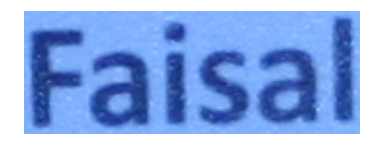

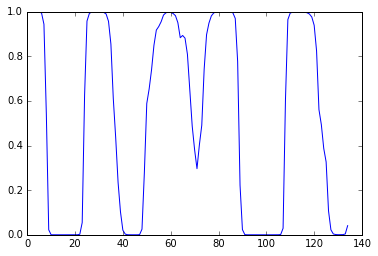

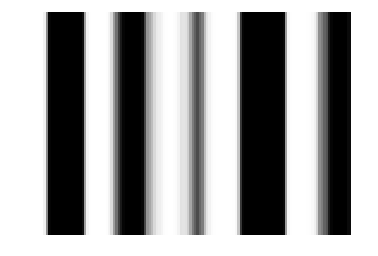

In [24]:
# plot heatmap
heatmap = predict_detect[:, 1].reshape((patches.shape[0], patches.shape[1]))

pylab.imshow(img_color)
pylab.axis('off')
pylab.show()

predict_signal = np.reshape(heatmap, patches.shape[1]*patches.shape[0])
pylab.plot(predict_signal)
pylab.show()

pylab.pcolor(heatmap[::-1])
pylab.gray()
pylab.axis('off')
pylab.show()

In [25]:
# non-max supression
peakind = np.nonzero(maximum_filter(predict_signal, size=(patches.shape[1] / 5)*0.75) == predict_signal)[0]

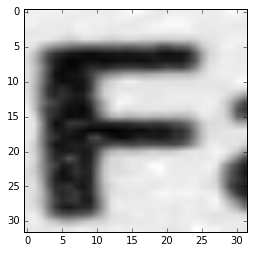

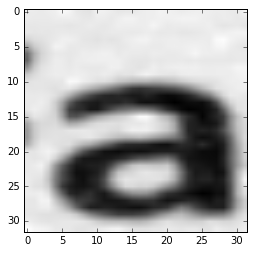

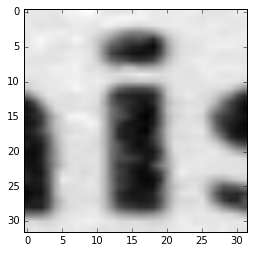

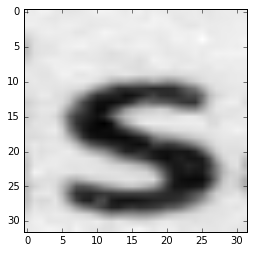

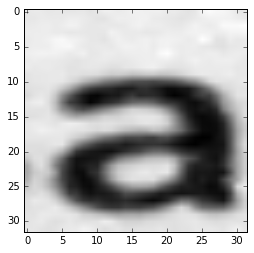

In [26]:
# show detected patches
for i in peakind:
    pylab.imshow(tester[i, 0, :, :])
    pylab.gray()
    pylab.show()

In [13]:
# recognize patches
word = np.zeros((len(peakind), 1, 32, 32), dtype = 'float32')
for idx, item in enumerate(peakind):
    word[idx, ...] = tester[item, 0, :, :]
    
predict_recognize = recognizer.predict(word)

In [14]:
# spell check for errors
real_pred = classer(predict_recognize)
real_pred = map(str, real_pred)
letter_stream = ''.join(real_pred).lower()
to_print = 'Probable words: ', ', '.join(correct(letter_stream))

In [15]:
# show output
gui = tk.Tk()

customFont = tkFont.Font(size = 20)

label = tk.Label(gui, text = to_print, font = customFont)
label.pack()

gui.mainloop()

In [ ]:
visualize.plot_conv_weights(detector.layers_['conv1'])

In [ ]:
visualize.plot_conv_weights(detector.layers_['conv2'])

In [ ]:
visualize.plot_conv_weights(detector.layers_['conv3'])

In [ ]:
visualize.plot_conv_weights(detector.layers_['hidden'])